In [1]:
import warnings
warnings.filterwarnings("ignore")



In [2]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from shapely.geometry import Point
import pandas as pd
from matplotlib.lines import Line2D
from shapely.ops import nearest_points
from shapely.geometry import Point
from shapely.geometry import LineString
import networkx as nx
import plotly.graph_objects as go



# Suppress warnings
ox.settings.log_console = False
ox.settings.use_cache = True

In [3]:
place = "Islamabad, Pakistan"

boundary = ox.geocode_to_gdf(place)
gdf_utm = gpd.read_file("preprocessedData/utm_point.gpkg")
utm_crs = gdf_utm.crs
print("UTM CRS:", utm_crs)

UTM CRS: EPSG:32643


In [4]:
all_pois = gpd.read_file("preprocessedData/all_pois.gpkg", layer='pois')
G = ox.load_graphml("preprocessedData/network.graphml")
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
major_roads = edges[edges['highway'].isin(['primary', 'secondary', 'trunk'])]


In [5]:
# Project all data to UTM
boundary = boundary.to_crs(utm_crs)
all_pois = all_pois.to_crs(utm_crs)
G = ox.project_graph(G, to_crs=utm_crs)


In [6]:
metro_routes = gpd.read_file('metro-data/islamabad_sections.geojson').to_crs(utm_crs)
metro_service_areas = gpd.GeoDataFrame(geometry=metro_routes.buffer(500), crs=utm_crs)


In [7]:
population = gpd.read_file("preprocessedData/population_clusters.gpkg")
stations = gpd.read_file("preprocessedData/snapped_stations.gpkg")


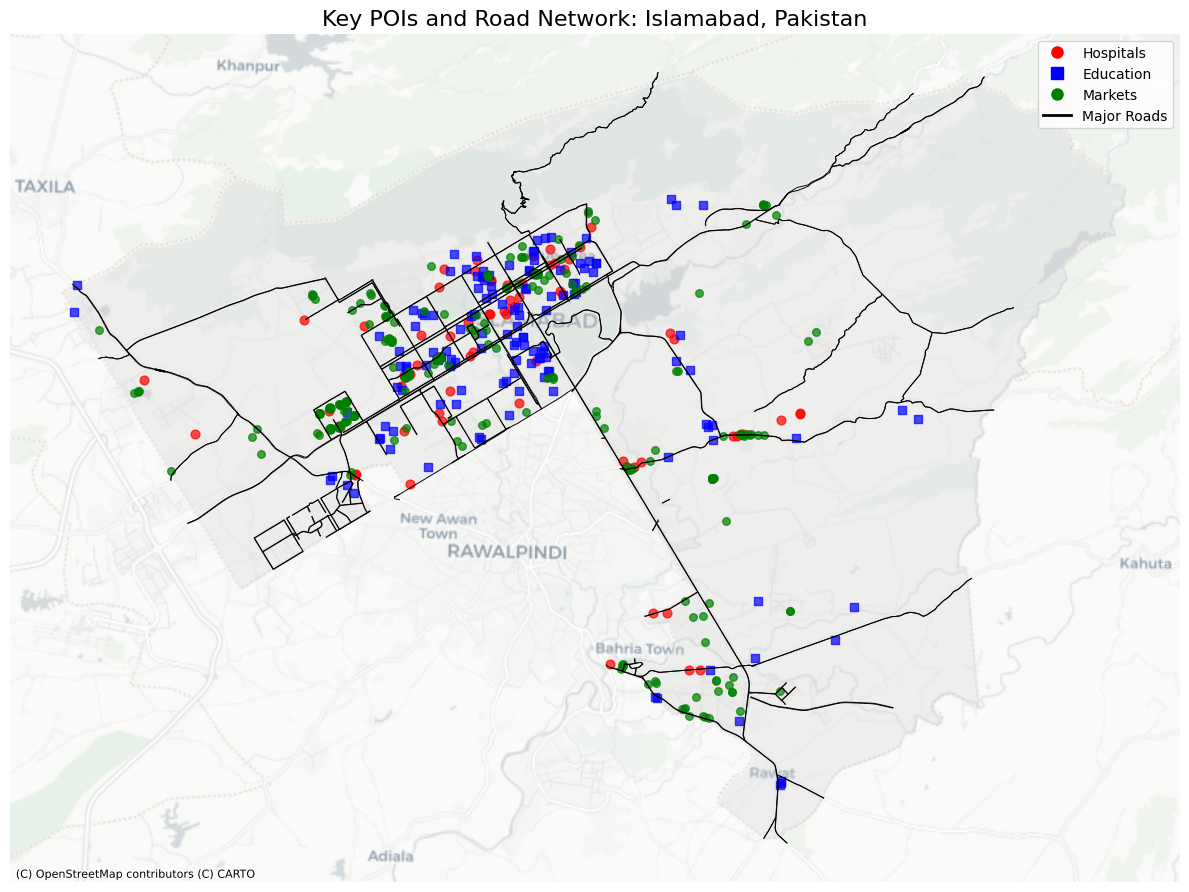


- Hospitals: 75
- Educations: 139
- Markets: 273
- Total POIs: 487
- Road Network: 96504 edges



In [8]:

fig, ax = plt.subplots(figsize=(12, 10))


boundary.plot(ax=ax, color='lightgray', edgecolor='white', alpha=0.3)
major_roads.plot(ax=ax, color='black', linewidth=0.7)


poi_colors = {'hospital': 'red', 'education': 'blue', 'market': 'green'}
for ptype, color in poi_colors.items():
    subset = all_pois[all_pois['type'] == ptype]
    subset.plot(ax=ax, color=color, markersize=30 + 10*(ptype == 'hospital'), 
               alpha=0.7, marker='o' if ptype != 'education' else 's')

ctx.add_basemap(ax, crs=utm_crs, source=ctx.providers.CartoDB.Positron)

legend_elements = [
    Line2D([0], [0], color='red', lw=0, marker='o', markersize=8, label='Hospitals'),
    Line2D([0], [0], color='blue', lw=0, marker='s', markersize=8, label='Education'),
    Line2D([0], [0], color='green', lw=0, marker='o', markersize=8, label='Markets'),
    Line2D([0], [0], color='black', lw=2, label='Major Roads')
]
ax.legend(handles=legend_elements, loc='upper right')
ax.set_title(f"Key POIs and Road Network: {place}", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.savefig('islamabad_pois_network.png', dpi=300)
plt.show()

print("\n" + "="*50)

for ptype in all_pois['type'].unique():
    count = (all_pois['type'] == ptype).sum()
    print(f"- {ptype.capitalize()}s: {count}")

print(f"- Total POIs: {len(all_pois)}")
print(f"- Road Network: {len(edges)} edges")
print("="*50 + "\n")

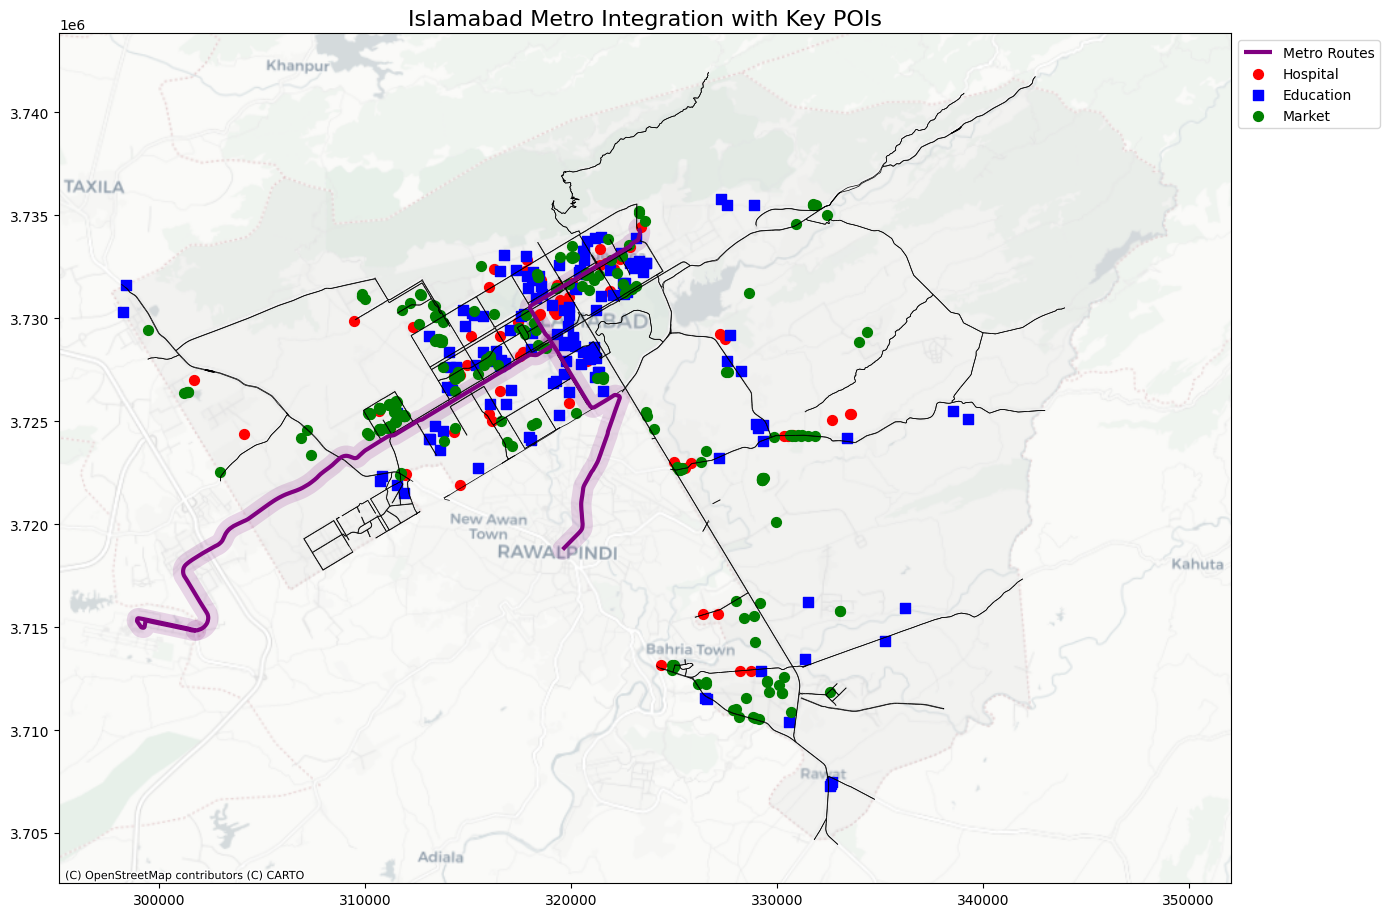

In [9]:
fig, ax = plt.subplots(figsize=(14, 12))

boundary.plot(ax=ax, color='lightgray', alpha=0.2)
major_roads.plot(ax=ax, color='black', linewidth=0.5)

metro_routes.plot(ax=ax, color='purple', linewidth=3, label='Metro Routes')
metro_service_areas.plot(ax=ax, color='purple', alpha=0.15, label='500m Service Area')

poi_colors = {'hospital':'red', 'education':'blue', 'market':'green'}
for ptype, color in poi_colors.items():
    all_pois[all_pois['type']==ptype].plot(
        ax=ax, color=color, markersize=50, marker='o' if ptype!='education' else 's',
        label=ptype.capitalize()
    )

ctx.add_basemap(ax, crs=utm_crs, source=ctx.providers.CartoDB.Positron)
ax.set_title("Islamabad Metro Integration with Key POIs", fontsize=16)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('metro_integration.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
underserved_pois = all_pois[~all_pois.geometry.within(metro_service_areas.unary_union)]


population = population.to_crs(metro_service_areas.crs)

# 3. Calculate served vs unserved population
served_pop = population[population.geometry.within(metro_service_areas.unary_union)]
unserved_pop = population[~population.geometry.within(metro_service_areas.unary_union)]

# 4. Print metrics

print(f"""
Metro Accessibility Report:
- POIs served: {len(all_pois) - len(underserved_pois)}/{len(all_pois)} 
  ({len(underserved_pois)} underserved)
- Population served: {served_pop['population'].sum():,.0f} 
  ({unserved_pop['population'].sum():,.0f} unserved)
- Key underserved areas:
  {underserved_pois.groupby('type').size().to_dict()}
""")




Metro Accessibility Report:
- POIs served: 88/487 
  (399 underserved)
- Population served: 162,042 
  (1,871,057 unserved)
- Key underserved areas:
  {'education': 118, 'hospital': 60, 'market': 221}



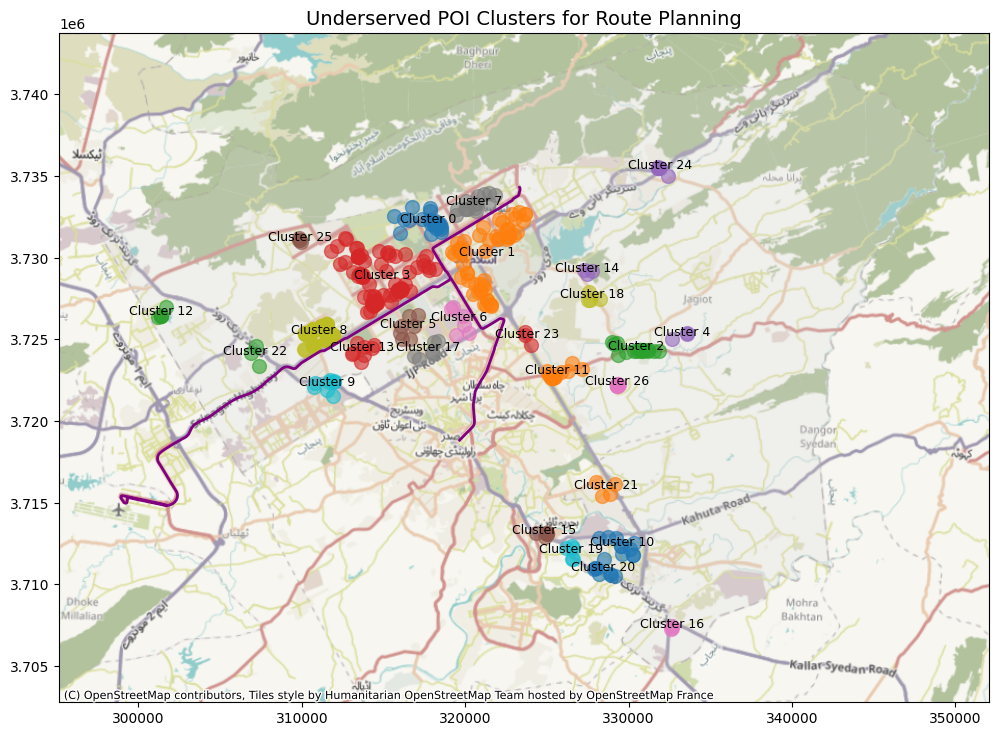

In [11]:
from sklearn.cluster import DBSCAN

# Cluster underserved POIs to identify demand hotspots
coords = np.array([[p.x, p.y] for p in underserved_pois.geometry])
db = DBSCAN(eps=1000, min_samples=3).fit(coords)  # 1km radius, min 3 POIs

underserved_pois['cluster'] = db.labels_
valid_clusters = underserved_pois[underserved_pois['cluster'] != -1]

# Visualize clusters
fig, ax = plt.subplots(figsize=(12, 10))
boundary.plot(ax=ax, color='lightgray', alpha=0.2)
metro_routes.plot(ax=ax, color='purple', linewidth=2)

for cluster_id in valid_clusters['cluster'].unique():
    cluster = valid_clusters[valid_clusters['cluster'] == cluster_id]
    cluster.plot(ax=ax, markersize=100, alpha=0.6)
    ax.annotate(
        f"Cluster {cluster_id}", 
        (cluster.geometry.centroid.x.mean(), cluster.geometry.centroid.y.mean()),
        fontsize=9, ha='center'
    )

ctx.add_basemap(ax, crs=utm_crs)
plt.title("Underserved POI Clusters for Route Planning", fontsize=14)
plt.show()